In [40]:
# Import libraries and datafiles
import pandas as pd
import numpy as np
import re
from patsy import dmatrices
import matplotlib.pyplot as plt
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import warnings
%pylab inline
warnings.filterwarnings("ignore")

train = pd.read_csv("train_cleaned.csv")
test = pd.read_csv("test_cleaned.csv")

train["Pclass"] = train["Pclass"].astype(str)
test["Pclass"] = test["Pclass"].astype(str)

Populating the interactive namespace from numpy and matplotlib


In [2]:
pip install h2o

     |████████████████████████████████| 129.4MB 85kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.3-py2.py3-none-any.whl size=129446676 sha256=338b4257d7e277a7f68261b1056112458855d265867168b204739ff94fc68f8d
  Stored in directory: /root/.cache/pip/wheels/3d/e6/07/53ce9be9cb61b33a79cb3ed1fc39f2dae84f6ee6fe1e373e5e
Successfully built h2o


In [5]:
# Starting h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpo9ylswh3
  JVM stdout: /tmp/tmpo9ylswh3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpo9ylswh3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_edklnu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [11]:
# Preparing data for random forest
features = ["Survived","Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title", "FamilySize"]
factor_columns = ["Pclass", "Sex", "Embarked", "Title"]
response = "Survived"

train_h2o = h2o.H2OFrame(train)
for col in factor_columns:
    train_h2o[col] = train_h2o[col].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
# Running Random Forest model to identify which variables are most important
model = h2o.estimators.H2ORandomForestEstimator(ntrees = 2000, max_depth = 30, nfolds = 5, seed = 0)
model.train(x = features, y = response, training_frame = train_h2o)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
# Creating list of features by importance

names = list(pd.DataFrame(model.varimp()).iloc[:,0])
importance = list(pd.DataFrame(model.varimp()).iloc[:,3])
feature_importance = pd.Series(data = importance, index = names, name = "Feature Importance")
feature_importance

Title         0.243839
Fare          0.187838
Age           0.185726
Sex           0.164040
Pclass        0.091428
FamilySize    0.053393
SibSp         0.029247
Embarked      0.028503
Parch         0.015987
Name: Feature Importance, dtype: float64

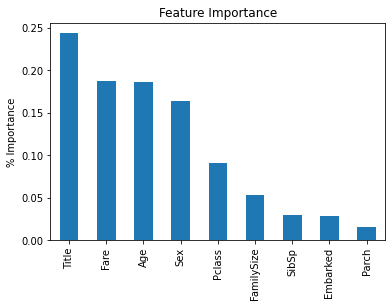

In [29]:
feature_importance.plot(kind = "bar", title = "Feature Importance")
plt.ylabel("% Importance")
plt.show()

In [42]:
# Build a deeper tree
Y, X = dmatrices("Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + Title + FamilySize", train, return_type = "dataframe")
y = Y["Survived"].values

from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 30, min_samples_split = 10, min_impurity_decrease = 0.005)
clf.fit(X, y)

from graphviz import Source
Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns))

graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns))
graph.format = 'png'
graph.render('dtree-imp-.005',view=True)

'dtree-imp-.005.png'